<a href="https://colab.research.google.com/github/ilan2002/Gesture_detection/blob/main/notebookada6dd9294.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition

# Import required libraries

In [1]:
!pip install tensorflow

In [2]:
from keras.layers import Conv3D, MaxPooling3D, MaxPooling2D # Import directly from keras.layers
#from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
import numpy as np
import os
import imageio # To imread and imresize
import datetime
from PIL import Image # To imread and imresize
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation,Dropout
#from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet

In [3]:
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

# Upload the dataset in colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = "/content/drive/MyDrive/gesture"  # Change to your preferred location

In [ ]:
import os
# Clone the GitHub repository
!git clone https://github.com/imsparsh/Gesture-Recognition-Dataset.git {dataset_path}

Cloning into '/content/drive/MyDrive/gesture'...
remote: Enumerating objects: 23539, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 23539 (delta 3), reused 2 (delta 0), pack-reused 23530 (from 1)
Receiving objects: 100% (23539/23539), 1.58 GiB | 20.39 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (22895/22895), done.


In [ ]:
# # Set the path of the file
# path_to_dataset = "/content/drive/MyDrive/Gesture_Recognition/Project_data.zip"
# path = "/content/drive/MyDrive/Gesture_Recognition/Project_data"

In [ ]:
# ! ls /content/drive/MyDrive/Gesture_Recognition

In [ ]:
# # Unzip the dataset from google drive in local environment in the folder dataset
# import zipfile
# zip_ref = zipfile.ZipFile(path_to_dataset, 'r')
# zip_ref.extractall("/dataset")
# zip_ref.close()

# Read the Folder Names for Training and Validation.

**Note:** Set the batch size in such a way that we can use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

In [6]:
folder_name ="/content/drive/MyDrive/gesture"
train_doc = np.random.permutation(open(folder_name + '/train.csv').readlines())
val_doc = np.random.permutation(open(folder_name + '/val.csv').readlines())
batch_size = 64     #experiment with the batch size

# Plot the graphs for Training and validation, accuracy and loss function

In [7]:
# Plot the graph for accuracy and loss of both training and validation dataset

def plot(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(num_epochs)
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


# Create Callback directory function

In [8]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
def callback_directory(curr_dt_time):
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

  if not os.path.exists(model_name):
    os.mkdir(model_name)

  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
  callbacks_list = [checkpoint, LR]
  return callbacks_list

# Customized Generator Function

**Generator**

Generator is one of the most important part of the code. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with img_idx, y,z and normalization such that we get high accuracy.

In [9]:
# Normalize the image by dividing the pixel values by 255 which resuilts the values range from 0 to 1
def normalise1(image):
  return image/255.

def generator(source_path, folder_list, batch_size,y,z,normalise):
    print( 'Source path = ', source_path, '; batch size =', batch_size,';Image resolution = ({},{})'.format(y,z))
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  int(len(t)/batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if(image.size[0] == 160): # crop the image of shape 120 X 160 to make it  120 X120
                      image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120

                    image = image.resize(size = (y,z)) #imageio.imresize(image,(y,z)).astype(np.float32)
                    image = np.asarray(image).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches

        if (len(t) % batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = Image.open(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    if image.size[0] == 160:
                        image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120

                    image = image.resize(size = (y,z))
                    image = np.asarray(image).astype(np.float32)


                    batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

# Read the sample image and understand the image properties. Do some experiments with sample image

In [10]:
imgs = os.listdir(folder_name+'/train/'+ train_doc[0].split(';')[0]) # read a sample sequence of images (a video) from the folder
image = imageio.imread(folder_name+'/train/'+ train_doc[0].strip().split(';')[0]+'/'+imgs[0]).astype(np.float32)
image

<ipython-input-10-0be124a9db4f>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(folder_name+'/train/'+ train_doc[0].strip().split(';')[0]+'/'+imgs[0]).astype(np.float32)


array([[[ 94.,  62.,  48.],
        [ 97.,  62.,  49.],
        [103.,  66.,  53.],
        ...,
        [ 21.,  33.,  31.],
        [ 20.,  32.,  30.],
        [ 18.,  29.,  28.]],

       [[ 98.,  63.,  50.],
        [100.,  64.,  51.],
        [104.,  65.,  53.],
        ...,
        [ 72.,  84.,  82.],
        [ 53.,  64.,  63.],
        [ 41.,  53.,  51.]],

       [[ 94.,  57.,  44.],
        [ 96.,  57.,  45.],
        [100.,  59.,  48.],
        ...,
        [ 94., 106., 104.],
        [ 89., 101.,  97.],
        [ 84.,  96.,  92.]],

       ...,

       [[ 52.,  37.,  33.],
        [ 62.,  47.,  43.],
        [133., 120., 115.],
        ...,
        [  5.,   3.,   1.],
        [ 10.,   6.,   3.],
        [ 13.,   8.,   5.]],

       [[ 42.,  30.,  23.],
        [ 49.,  37.,  30.],
        [176., 166., 158.],
        ...,
        [  3.,   3.,   3.],
        [  9.,   7.,   5.],
        [ 10.,   8.,   6.]],

       [[ 69.,  56.,  49.],
        [ 49.,  37.,  30.],
        [194., 1

In [11]:
imgs

['WIN_20180926_16_54_08_Pro_00006.png',
 'WIN_20180926_16_54_08_Pro_00008.png',
 'WIN_20180926_16_54_08_Pro_00010.png',
 'WIN_20180926_16_54_08_Pro_00012.png',
 'WIN_20180926_16_54_08_Pro_00014.png',
 'WIN_20180926_16_54_08_Pro_00016.png',
 'WIN_20180926_16_54_08_Pro_00018.png',
 'WIN_20180926_16_54_08_Pro_00020.png',
 'WIN_20180926_16_54_08_Pro_00022.png',
 'WIN_20180926_16_54_08_Pro_00024.png',
 'WIN_20180926_16_54_08_Pro_00026.png',
 'WIN_20180926_16_54_08_Pro_00028.png',
 'WIN_20180926_16_54_08_Pro_00030.png',
 'WIN_20180926_16_54_08_Pro_00032.png',
 'WIN_20180926_16_54_08_Pro_00034.png',
 'WIN_20180926_16_54_08_Pro_00036.png',
 'WIN_20180926_16_54_08_Pro_00038.png',
 'WIN_20180926_16_54_08_Pro_00040.png',
 'WIN_20180926_16_54_08_Pro_00042.png',
 'WIN_20180926_16_54_08_Pro_00044.png',
 'WIN_20180926_16_54_08_Pro_00046.png',
 'WIN_20180926_16_54_08_Pro_00048.png',
 'WIN_20180926_16_54_08_Pro_00050.png',
 'WIN_20180926_16_54_08_Pro_00052.png',
 'WIN_20180926_16_54_08_Pro_00054.png',


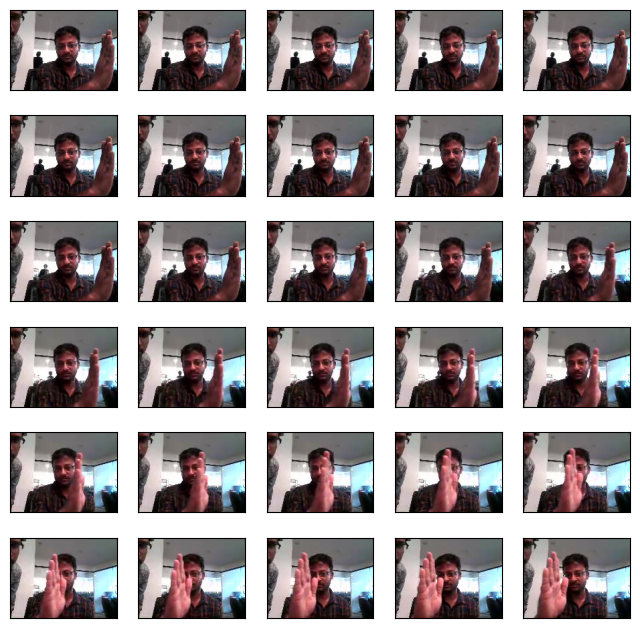

(120, 160, 3)
***********************After Resize*******************************************
(100, 100, 3)


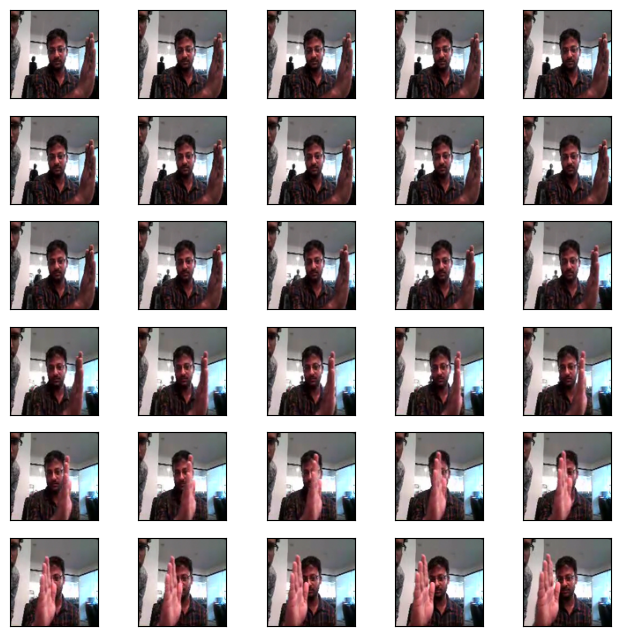

In [12]:
import matplotlib.pyplot as plt

from PIL import Image

imgs = os.listdir(folder_name+'/train/'+ train_doc[0].split(';')[0]) # read a sample sequence of images (a video) from the folder
plt.figure(figsize=(8,8))
for item in range(len(imgs)): #  Iterate over the frames/images of a folder to read them in
  im = Image.open(folder_name+'/train/'+ train_doc[0].split(';')[0] +"/"+ imgs[item])
  im = np.asarray(im)
  plt.subplot(6,5,item+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(im)

plt.show()
print(im.shape)
print('***********************After Resize*******************************************')
plt.figure(figsize=(8,8))
for item in range (len(imgs)):
  im = Image.open(folder_name + '/train/' + train_doc[0].split(';')[0] + '/' + imgs[item])
  im = im.resize(size =(100,100))
  im = np.asarray(im)
  plt.subplot(6,5,item+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(im)

print(im.shape)




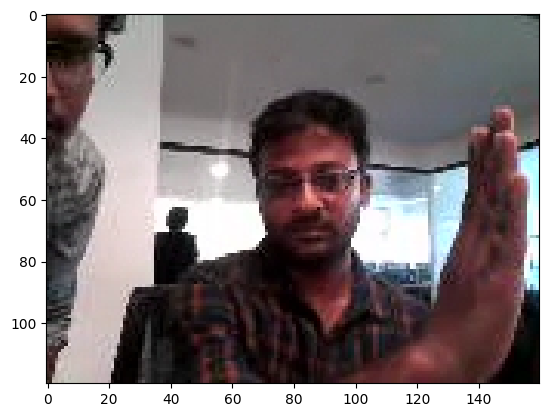

In [13]:
im = Image.open(folder_name + '/train/' + train_doc[0].split(';')[0] + '/' + imgs[0])
plt.imshow(im)

In [14]:
im.size

(160, 120)

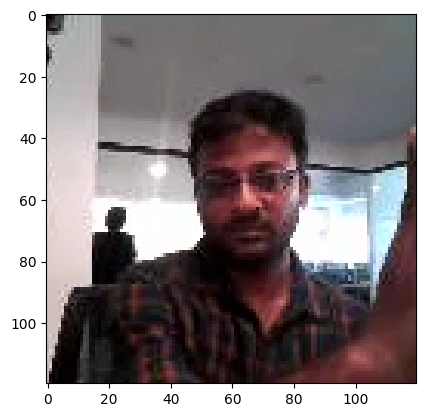

In [15]:
# Crop the sample image
width, height =im.size
left = 20
top = 0
right = width - 20
bottom = height
im = np.array(im.crop((left,top,right,bottom)))
plt.imshow(im)

In [16]:
im.shape

(120, 120, 3)

**Note:** The dataset has 2 different size images (360 X 360 ) and (160 X 120)

In [17]:
arr = np.array([[120,130,255],[250,255,0],[166,255,1]])
arr/255.

array([[0.47058824, 0.50980392, 1.        ],
       [0.98039216, 1.        , 0.        ],
       [0.65098039, 1.        , 0.00392157]])

## Model

Here we make the model using different functionalities that Keras provides.
1. `Conv3D` and `MaxPooling3D` for a 3D convolution model. The last layer is the softmax.
2. `TimeDistributed` while building a Conv2D + RNN model.  The last layer is the softmax.

 **Note:** We have to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Conv3d Model architecture

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def Conv3dArchitecture(x,y,z):
  conv3d_model = Sequential()
  conv3d_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Flatten())
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(512, activation='relu'))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

# **Note:** The next step is to compile the model. When we print the summary of the model, we will see the total number of parameters we have to train.


**Note:**
Number of parameters depends on number of filters , filter size, number of layers, number of frames in a sequence, Image resolution, number of neurans in dense layers.

There are 30 frames in a sequence. To classify the video sequence we do not need all the frames.We can reduce the number of training parameters by reducing the number of frames in a sequence. So we will take the alternative frames of a sequence. [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] We are using 18 frames per video for training and validation.


In [ ]:
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx)
y = 100
z = 100
conv3d_model = Conv3dArchitecture(x,y,z)
conv3d_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 18, 100, 100, 64)    │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 18, 100, 100, 64)    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 18, 100, 100, 64)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 9, 50, 50, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 9, 50, 50, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 9, 50, 50, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 9, 50, 50, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 4, 25, 25, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 4, 25, 25, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 25, 25, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 4, 25, 25, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 12, 12, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 2, 12, 12, 256)      │       1,769,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 12, 12, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 2, 12, 12, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 6, 6, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,605,765 (29.01 MB)

 Trainable params: 7,604,357 (29.01 MB)

 Non-trainable params: 1,408 (5.50 KB)

None


In [ ]:
# Just to check the file name format
import datetime as dt
curr_dt_time = dt.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(curr_dt_time)
print(model_name)



2025-03-28 02:35:50.633539
model_init_2025-03-2802_35_50.633539/


In [ ]:
# Set the time to give unique filename to each checkpoint
import datetime
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/gesture/train'
val_path = '/content/drive/MyDrive/gesture/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

**Note:** Let us now fit the model. This will start training the model and with the help of the checkpoints, we will be able to save the model at the end of each epoch.

In [ ]:
# Count the sample dataset for each class
num =list(map(lambda x : x.replace('\n','')[-1], train_doc))
print(num.count('0'))
print(num.count('1'))
print(num.count('2'))
print(num.count('3'))
print(num.count('4'))

136
137
130
137
123


## Let us create a dummy model to check the Conv3d model architecture is working correcly or not, with small dataset and less epoch

In [ ]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator.

batch_size = 32
y = 100 # (y,z) is the Image resolution
z = 100
normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc[0:160], batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc[0:40], batch_size,y,z,normalise)
num_epochs = 20

history = conv3d_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0) # Removed workers argument

Source path =  /content/drive/MyDrive/gesture/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2279 - loss: 3.9713Source path =  /content/drive/MyDrive/gesture/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2025-03-2802_35_53.833150/model-00001-3.47934-0.26705-1.57299-0.22500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - categorical_accuracy: 0.2312 - loss: 3.9303 - val_categorical_accuracy: 0.2250 - val_loss: 1.5730 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4491 - loss: 2.0066
Epoch 2: saving model to model_init_2025-03-2802_35_53.833150/model-00002-1.67614-0.49432-1.63317-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - categorical_accuracy: 0.4528 - loss: 1.9790 - val_categorical_accuracy: 0.0750 - val_loss: 1.6332 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4914 - loss: 1.3825
Epoch 3: saving model to model_init_2025-03-2802_35_53.833150/model-00003-1.20809-0.55682-1.78394-0.07500.h5



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - categorical_accuracy: 0.4969 - loss: 1.3680 - val_categorical_accuracy: 0.0750 - val_loss: 1.7839 - learning_rate: 0.0010
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.5788 - loss: 1.0652
Epoch 4: saving model to model_init_2025-03-2802_35_53.833150/model-00004-0.87157-0.65625-1.94243-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - categorical_accuracy: 0.5853 - loss: 1.0491 - val_categorical_accuracy: 0.0750 - val_loss: 1.9424 - learning_rate: 5.0000e-04
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.6648 - loss: 0.8559
Epoch 5: saving model to model_init_2025-03-2802_35_53.833150/model-00005-0.76894-0.68750-2.11896-0.07500.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - categorical_accuracy: 0.6666 - loss: 0.8486 - val_categorical_accuracy: 0.0750 - val_loss: 2.1190 - learning_rate: 5.0000e-04
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.6819 - loss: 0.7796
Epoch 6: saving model to model_init_2025-03-2802_35_53.833150/model-00006-0.69858-0.72159-2.30121-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - categorical_accuracy: 0.6852 - loss: 0.7728 - val_categorical_accuracy: 0.0750 - val_loss: 2.3012 - learning_rate: 2.5000e-04
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7738 - loss: 0.6162
Epoch 7: saving model to model_init_2025-03-2802_35_53.833150/model-00007-0.61064-0.77557-2.46212-0.07500.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - categorical_accuracy: 0.7739 - loss: 0.6158 - val_categorical_accuracy: 0.0750 - val_loss: 2.4621 - learning_rate: 2.5000e-04
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7420 - loss: 0.6846
Epoch 8: saving model to model_init_2025-03-2802_35_53.833150/model-00008-0.61665-0.75852-2.65340-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - categorical_accuracy: 0.7434 - loss: 0.6790 - val_categorical_accuracy: 0.0750 - val_loss: 2.6534 - learning_rate: 1.2500e-04
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7005 - loss: 0.6595
Epoch 9: saving model to model_init_2025-03-2802_35_53.833150/model-00009-0.59148-0.73580-2.79843-0.07500.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - categorical_accuracy: 0.7035 - loss: 0.6538 - val_categorical_accuracy: 0.0750 - val_loss: 2.7984 - learning_rate: 1.2500e-04
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7740 - loss: 0.5304
Epoch 10: saving model to model_init_2025-03-2802_35_53.833150/model-00010-0.52809-0.79545-2.93738-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - categorical_accuracy: 0.7758 - loss: 0.5302 - val_categorical_accuracy: 0.0750 - val_loss: 2.9374 - learning_rate: 6.2500e-05
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7954 - loss: 0.4840
Epoch 11: saving model to model_init_2025-03-2802_35_53.833150/model-00011-0.53230-0.78693-3.08382-0.07500.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - categorical_accuracy: 0.7947 - loss: 0.4880 - val_categorical_accuracy: 0.0750 - val_loss: 3.0838 - learning_rate: 6.2500e-05
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.8025 - loss: 0.5147
Epoch 12: saving model to model_init_2025-03-2802_35_53.833150/model-00012-0.46161-0.81534-3.20677-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - categorical_accuracy: 0.8036 - loss: 0.5103 - val_categorical_accuracy: 0.0750 - val_loss: 3.2068 - learning_rate: 3.1250e-05
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.8401 - loss: 0.4670
Epoch 13: saving model to model_init_2025-03-2802_35_53.833150/model-00013-0.50696-0.80682-3.32177-0.07500.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - categorical_accuracy: 0.8373 - loss: 0.4703 - val_categorical_accuracy: 0.0750 - val_loss: 3.3218 - learning_rate: 3.1250e-05
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7814 - loss: 0.5143
Epoch 14: saving model to model_init_2025-03-2802_35_53.833150/model-00014-0.49572-0.79545-3.42926-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - categorical_accuracy: 0.7826 - loss: 0.5128 - val_categorical_accuracy: 0.0750 - val_loss: 3.4293 - learning_rate: 1.5625e-05
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7849 - loss: 0.6359
Epoch 15: saving model to model_init_2025-03-2802_35_53.833150/model-00015-0.60945-0.78125-3.52642-0.07500.h5



Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - categorical_accuracy: 0.7846 - loss: 0.6337 - val_categorical_accuracy: 0.0750 - val_loss: 3.5264 - learning_rate: 1.5625e-05
Epoch 16/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.8205 - loss: 0.4657
Epoch 16: saving model to model_init_2025-03-2802_35_53.833150/model-00016-0.45216-0.82670-3.61208-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - categorical_accuracy: 0.8210 - loss: 0.4645 - val_categorical_accuracy: 0.0750 - val_loss: 3.6121 - learning_rate: 1.0000e-05
Epoch 17/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8145 - loss: 0.4793
Epoch 17: saving model to model_init_2025-03-2802_35_53.833150/model-00017-0.51923-0.80682-3.68777-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - categorical_accuracy: 0.8139 - loss: 0.4826 - val_categorical_accuracy: 0.0750 - val_loss: 3.6878 - learning_rate: 1.0000e-05
Epoch 18/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7843 - loss: 0.5115
Epoch 18: saving model to model_init_2025-03-2802_35_53.833150/model-00018-0.49733-0.80682-3.76225-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - categorical_accuracy: 0.7862 - loss: 0.5103 - val_categorical_accuracy: 0.0750 - val_loss: 3.7623 - learning_rate: 1.0000e-05
Epoch 19/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8046 - loss: 0.5402
Epoch 19: saving model to model_init_2025-03-2802_35_53.833150/model-00019-0.52828-0.80966-3.81822-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - categorical_accuracy: 0.8050 - loss: 0.5392 - val_categorical_accuracy: 0.0750 - val_loss: 3.8182 - learning_rate: 1.0000e-05
Epoch 20/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.8024 - loss: 0.5214
Epoch 20: saving model to model_init_2025-03-2802_35_53.833150/model-00020-0.52703-0.77841-3.86875-0.07500.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - categorical_accuracy: 0.8004 - loss: 0.5218 - val_categorical_accuracy: 0.0750 - val_loss: 3.8687 - learning_rate: 1.0000e-05


In [ ]:
# Save the trained model
save_path = "/content/drive/MyDrive/models/final_model.h5"  # Change this to your desired path
conv3d_model.save(save_path)
print(f"Model saved at: {save_path}")
print("Model saved successfully!")

Model saved at: /content/drive/MyDrive/models/final_model.h5
Model saved successfully!


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install tensorflow-addons --upgrade --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
import tensorflow as tf

save_path_tflite = "/content/drive/MyDrive/models/model.tflite"

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(conv3d_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: Quantization

# Enable TF Select to support MaxPool3D
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()

# Save the TFLite model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved as model.tflite")

# Save the TFLite model
with open(save_path_tflite, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {save_path_tflite}")
print("TFLite model saved as model.tflite")

Saved artifact at '/tmp/tmp2bmxfv5l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 18, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133763032195792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133763032192720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133763032192912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133763032191952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133763032193296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133763032193104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133763032188304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133763032189072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133763032190032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133763032187920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1337630321

In [ ]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.18.0
    Uninstalling tf_keras-2.18.0:
      Successfully uninstalled tf_keras-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible

In [ ]:
import tensorflow as tf

# Path to your saved .h5 model
h5_model_path = "/content/drive/MyDrive/models/final_model.h5"

# Load the Keras model
model = tf.keras.models.load_model(h5_model_path)

# Verify the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 18, 100, 100, 64)    │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 18, 100, 100, 64)    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 18, 100, 100, 64)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 9, 50, 50, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 9, 50, 50, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 9, 50, 50, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 9, 50, 50, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 4, 25, 25, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 4, 25, 25, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 25, 25, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 4, 25, 25, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 12, 12, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 2, 12, 12, 256)      │       1,769,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 12, 12, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 2, 12, 12, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 6, 6, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,605,767 (29.01 MB)

 Trainable params: 7,604,357 (29.01 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
!pip install tensorflow==2.18.0  # Install a compatible TensorFlow version
!pip install tensorflow-text==2.18.1  # Align with the selected TensorFlow version
!pip install tensorflow-addons==0.20.0  # Ensure compatible tensorflow-addons
!pip install tensorflowjs --upgrade # Upgrade tensorflowjs again
!pip install packaging==23.1  # align with the selected packaging version

  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
Using cached packaging-23.2-py3-none-any.whl (53 kB)
Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.9 MB)
Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting un

In [ ]:
import tensorflowjs as tfjs

# Define output directory for TFJS model
tfjs_output_dir = "/content/drive/MyDrive/models/tfjs"

# Convert the Keras model to TensorFlow.js format
tfjs.converters.save_keras_model(model, tfjs_output_dir)

print(f"TensorFlow.js model saved at {tfjs_output_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
TensorFlow.js model saved at /content/drive/MyDrive/models/tfjs


In [ ]:
import shutil
from google.colab import files

# Zip the TFJS model folder
shutil.make_archive("tfjs_model", 'zip', tfjs_output_dir)

# Download the file
files.download("tfjs_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/models/model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']

print("Output shape:", output_shape)
print("Number of classes:", output_shape[-1])

# Print model details
print("Input Details:", input_details)
print("Output Details:", output_details)

# Load and preprocess the input image
def preprocess_image(image_paths, target_size):
    """Loads and preprocesses a sequence of images."""
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    processed_images = []

    for idx, item in enumerate(img_idx):
        image = image_paths[item]
        image = cv2.imread(image)  # Load image
        image = cv2.resize(image, target_size)  # Resize to model input size
        image = image.astype(np.float32) / 255.0  # Normalize

        processed_images.append(image)

    input_data = np.stack(processed_images, axis=0)
    input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension

    return input_data

# Path to the test image
image_dir = "/content/drive/MyDrive/gesture/train/WIN_20180907_16_29_34_Pro_Right Swipe_new"
target_size = (100, 100)
image_paths = [os.path.join(image_dir, filename) for filename in sorted(os.listdir(image_dir))]

# Preprocess the image
input_data = preprocess_image(image_paths, target_size)

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get output predictions
output_data = interpreter.get_tensor(output_details[0]['index'])[0]  # Extract batch index 0

# Print classification results
predicted_class = np.argmax(output_data)  # Get class with highest probability
print("Predicted Class:", predicted_class)

# Print confidence scores for all 5 classes
for i, confidence in enumerate(output_data):
    print(f"Class {i}: {confidence:.4f}")


Output shape: [1 5]
Number of classes: 5
Input Details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1,  18, 100, 100,   3], dtype=int32), 'shape_signature': array([ -1,  18, 100, 100,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 45, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Predicted Class: 4
Class 0: 0.0048
Class 1: 0.0003
Class 2: 0.0126
Class 3: 0.3367
Class 4: 0.6456


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/models/model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print model details (optional)
# print("Input Details:", input_details)
# print("Output Details:", output_details)


# Load and preprocess the input image
def preprocess_image(image_paths, target_size):
    """Loads and preprocesses a sequence of images."""
    img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
    processed_images = []

    for idx, item in enumerate(img_idx):
        image = image_paths[item]
        image = cv2.imread(image)  # Load image
        image = cv2.resize(image, target_size)  # Resize to model input size
        image = image.astype(np.float32) / 255.0  # Normalize
        processed_images.append(image)

    # Stack images to create sequence and add batch dimension
    input_data = np.stack(processed_images, axis=0)
    input_data = np.expand_dims(input_data, axis=0)

    return input_data

# Path to the test images (directory containing a sequence)
image_dir = "/content/drive/MyDrive/gesture/train/WIN_20180907_16_35_51_Pro_Right Swipe_new"
target_size = (100, 100)
image_paths = [os.path.join(image_dir, filename) for filename in sorted(os.listdir(image_dir))]

# Preprocess the image sequence
input_data = preprocess_image(image_paths, target_size)

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get output predictions
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

# Print classification results
predicted_class = np.argmax(output_data)
print("Predicted Class:", predicted_class)

# Print confidence scores for all 5 classes
for i, confidence in enumerate(output_data):
    print(f"Class {i}: {confidence:.4f}")

Predicted Class: 4
Class 0: 0.0074
Class 1: 0.0004
Class 2: 0.0171
Class 3: 0.3569
Class 4: 0.6181


In [ ]:
print(history.history['loss'])
print(history.history['categorical_accuracy'])
print(history.history['val_loss'])
print(history.history['val_categorical_accuracy'])

[3.479336738586426, 1.6761425733566284, 1.2080867290496826, 0.8715705275535583, 0.7689386010169983, 0.6985828876495361, 0.6106441020965576, 0.6166513562202454, 0.5914759039878845, 0.5280935764312744, 0.5323023200035095, 0.4616087079048157, 0.5069601535797119, 0.4957178831100464, 0.6094453930854797, 0.45215943455696106, 0.5192301869392395, 0.49733006954193115, 0.5282783508300781, 0.5270310044288635]
[0.2670454680919647, 0.4943181872367859, 0.5568181872367859, 0.65625, 0.6875, 0.7215909361839294, 0.7755681872367859, 0.7585227489471436, 0.7357954382896423, 0.7954545617103577, 0.7869318127632141, 0.8153409361839294, 0.8068181872367859, 0.7954545617103577, 0.78125, 0.8267045617103577, 0.8068181872367859, 0.8068181872367859, 0.8096590638160706, 0.7784090638160706]
[1.5729920864105225, 1.6331732273101807, 1.7839438915252686, 1.942434310913086, 2.118962287902832, 2.3012101650238037, 2.4621176719665527, 2.6533992290496826, 2.7984347343444824, 2.9373831748962402, 3.0838191509246826, 3.2067704200

END OF CODE ....


Below are the different algorithm that can be used to train if you dont need remove it

**Note:**
1. The above dummy model shows that the accuracy for training data set is 56.13% for 2nd epoch and loss is decreasing.
2. This shows that the model is trying to learn.
3. We can now create the model with whole dataset for training and validation.


**Note:**
1. For batch_size =64 , we are getting the Error:ResourceExhaustedError
so we tried batch_size = 32

# Model1 - Conv3D Architecture
1. batch_size = 32
2. num_epochs = 20
3. Image resolution =(100 , 100)
4. Normalization method /255.

In [ ]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
def callback_directory(curr_dt_time):
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

  if not os.path.exists(model_name):
    os.mkdir(model_name)

  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
  callbacks_list = [checkpoint, LR]
  return callbacks_list

### Set the values of number of epochs, batch_size,Image resolution and number of images in sequence

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 2 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/content/drive/MyDrive/gesture/train'
val_path = '/content/drive/MyDrive/gesture/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 18, 100, 100, 64)    │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 18, 100, 100, 64)    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 18, 100, 100, 64)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 9, 50, 50, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 9, 50, 50, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 9, 50, 50, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 9, 50, 50, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 4, 25, 25, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 4, 25, 25, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 4, 25, 25, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 4, 25, 25, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 2, 12, 12, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 2, 12, 12, 256)      │       1,769,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 2, 12, 12, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 2, 12, 12, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 1, 6, 6, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,605,765 (29.01 MB)

 Trainable params: 7,604,357 (29.01 MB)

 Non-trainable params: 1,408 (5.50 KB)

None


In [ ]:

# Call the file path creating callback_dirctory function
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0) # Removed workers argument

Source path =  /content/drive/MyDrive/gesture/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/2
11/21 ━━━━━━━━━━━━━━━━━━━━ 31:11 187s/step - categorical_accuracy: 0.2083 - loss: 4.2254

# Visualising the training result of Model1

In [ ]:
#
acc = history_model1.history['categorical_accuracy']
val_acc = history_model1.history['val_categorical_accuracy']

loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


**Note:**

1. Each epoch is taking 40-45 sec for training.
2. Till 15th epoch the validation accuracy is poor and validation loss is very high. After 15th epoch the validation accuracy started improving and validation loss started decreasing.



# Model2 - Conv3D Architecture
1. batch_size = 32
2. num_epochs = 20
3. Image resolution =(80 , 80)
4. Normalization method /255.

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 80
z = 80

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

In [ ]:
# Call the file path creating callback_dirctory function
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# Visualizing the model accuracy and loss
#
acc = history_model1.history['categorical_accuracy']
val_acc = history_model1.history['val_categorical_accuracy']

loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

**Note:** There is no improvement in the performance of the model after reducing the resolution of the image

**Decision:** Set the image resolution (120,120)

**Note:**
1. We tried to create a Conv3D model by considering training image resolution (120,120)
2. We end up with the Error: ResourceExhaustedError  

**Decision:**
1. Change the batch size to 16 and keep Image Resolution (80,80) check the model performance.

# Model3 - Conv3D Architecture
1. batch_size = 16
2. num_epochs = 20
3. Image resolution =(80,80)
4. Normalization method /255.

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 16

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 80
z = 80

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

In [ ]:
# Call the file path creating callback_dirctory function
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

**Note:**
1. There is no improvement in the model performance
2. The loss of both training and validation dataset becomes nan means loss diverge to infinity.

**Decision:**
Let us change the Conv3D architecture by removing a layer of conv3d unit

# Take Model1 and run for more epochs

**Note:** Model1 is showing some improving training and validation accuracy and decreasing loss.   

**Decision:** We can increase the number of epochs for the model1 and check the result

# Model4 - Conv3D Architecture
1. batch_size = 32
2. num_epochs = 30 # Increase the number of epochs
3. Image resolution =(100 , 100)
4. Normalization method /255.

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 30 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

# Call the file path creating callback_dirctory function
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Let us create the train_generator and the val_generator which will be used in .fit.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)


#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



In [ ]:
#
acc = history_model1.history['categorical_accuracy']
val_acc = history_model1.history['val_categorical_accuracy']

loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


**Note:**
1. The above model shows that afetr 15th epoch the accuracy for validation dataset starts improving  and validation loss starts decreases.
2. This is a good sign we can get a good model with high validation accuracy and low validation loss if we train the model further.



# Conv3D Architecture 2
1. Reduce the training parameters

  a. By reducing the number of filters in each Conv3D layer

  b. By reducing the number of neurons in last dense layer


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def conv3d_architecture1(x,y,z):
  conv3d_model = Sequential()
  conv3d_model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Flatten())
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(256, activation='relu'))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

# CNN + RNN Stack Architecture

#### Here we make the model using different functionalities that Keras provides. We will use TimeDistributed, GRU and other RNN structures after doing transfer learning. Also the last layer is the softmax.

**Note:** Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

# Model 5 - CNN-LSTM Model
1. Transfer learning using VGG16 imagenet
2. batch_size = 32
3. Number of Epochs = 30
4. Image Size = 100*100
5. Optimizer = SGD

In [ ]:
def cnn_lstm(x,y,z):
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)

  for layer in base_model.layers:
      layer.trainable = False

  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))

  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(32))

  model.add(Dense(8, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model


In [ ]:

# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 30 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



In [ ]:
# Compile the conv3d_model
# Using sgd optimizer

sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model5 = cnn_lstm(x,y,z)
model5.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

In [ ]:
# Call the file path creating callback_dirctory function
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
history_model5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_model5)

**Observation**
1. Training Accuracy: 78
2. Validation Accuracy: 63
3. Train Loss: 0.95
4. Val Loss: 1.09
5. We need to explore more models to increase accuracy.

# Model 6 - CNN GRU and Transfer Learning
1. Transfer learning using VGG16 imagenet
2. batch_size = 32
3. Number of Epochs = 20
4. Image Size = 100*100
5. Optimizer = Adam

In [ ]:
def cnn_gru(x,y,z, dropout):

  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)

  for layer in base_model.layers:
      layer.trainable = False

  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(GRU(128, return_sequences=True))
  model.add(GRU(64))
  model.add(Dropout(dropout))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam()
model6 = cnn_gru(x,y,z,0.25)
model6.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

In [ ]:
# Call the file path creating callback_dirctory function
callbacks_list = callback_directory(curr_dt_time)


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
history_model6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_model6)

**Observation**
1. Training Accuracy: 99.8
2. Validation Accuracy: 85
3. Train Loss: 0.02
4. Val Loss: 0.64
5. This model is overfitting. So next we will apply some techniques to control overfitting.

# Model 6.2 CNN and GRU with transfer learning
Since the model is overfitting lets try learning rate for optimizer on the model 6


In [ ]:
adam = optimizers.Adam(learning_rate=0.0001)
model6_2 = cnn_gru(x,y,z, 0.25)
model6_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6_2.summary())

In [ ]:
#Fit the model
num_epochs=20
history_model6_2 = model6_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_model6_2)


**Observation**
1. Training Accuracy: 98
2. Validation Accuracy: 76
3. Train Loss: 0.12
4. Val Loss: 0.63
5. The model is still overfitting

# Model 6_3
Lets try to increase dropout values on the same model.

In [ ]:
adam = optimizers.Adam(learning_rate=0.0001)
model6_3 = cnn_gru(x,y,z, 0.5)
model6_3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6_3.summary())

In [ ]:
#Fit the model
num_epochs=20
history_model6_3 = model6_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_model6_3)


**Observation**
1. Training Accuracy: 92
2. Validation Accuracy: 77
3. Train Loss: 0.32
4. Val Loss: 0.62
5. The model is still overfitting.

# Model 6_4
Lets add more dropout layers to control overfitting.

In [ ]:
def cnn_gru_4(x,y,z, dropout):

  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)

  for layer in base_model.layers:
      layer.trainable = False

  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(GRU(128, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(64))
  model.add(Dropout(dropout))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 15 # choose the number of epochs
batch_size = 32

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam(learning_rate=0.0001)
model6_4 = cnn_gru_4(x,y,z,0.25)
model6_4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6_4.summary())

In [ ]:
# Call the file path creating callback_dirctory function
callbacks_list = callback_directory(curr_dt_time)


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
history_model6_4 = model6_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_model6_4)


**Observation**
1. Training Accuracy: 84
2. Validation Accuracy: 76
3. Train Loss: 0.57
4. Val Loss: 0.74
5. The model is less overfitting now but We need to explore more models to increase accuracy.

# Model 7
CNN, LSTM and GRU with transfer learning

In [ ]:
def cnn_lstm_gru(x,y,z, dropout):

  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)

  for layer in base_model.layers:
      layer.trainable = False

  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(LSTM(128, return_sequences=True))
  model.add(GRU(64, return_sequences=True))
  model.add(GRU(32))

  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam()
model7 = cnn_lstm_gru(x,y,z)
model7.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

In [ ]:
# Call the file path creating callback_dirctory function
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
num_epochs=20
history_model7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_model7)


**Observation**
1. Training Accuracy: 97
2. Validation Accuracy: 79
3. Train Loss: 0.11
4. Val Loss: 0.64
5. The model is overfitting and we need to control overfitting by providing learning rate and drop out layers

# Model 7_2
Try adding learning rate and dropout layers

In [ ]:
def cnn_lstm_gru(x,y,z, dropout):

  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)

  for layer in base_model.layers:
      layer.trainable = False

  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(64, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(32))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam(learning_rate=0.0001)
model7_2 = cnn_lstm_gru(x,y,z,0.25)
model7_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7_2.summary())

In [ ]:
# Call the file path creating callback_dirctory function
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model
num_epochs=15
history_model7_2 = model7_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_model7_2)


**Observation**
1. Training Accuracy: 93.9
2. Validation Accuracy: 81
3. Train Loss: 0.41
4. Val Loss: 0.66
5. Good model but we can still further try to decrease gap between training and validation accuracy

# Data Augmentation

# Using Augmentation techniques to improve the accuracy of the model

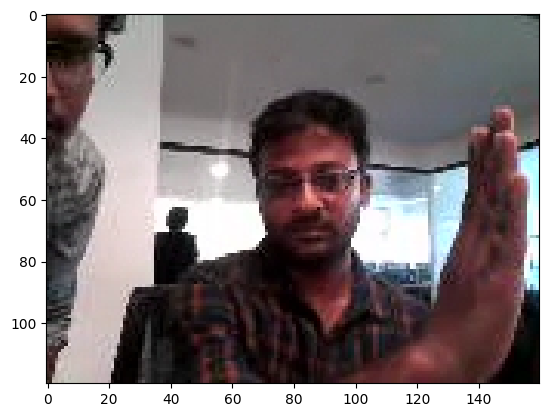

In [18]:
im = Image.open(folder_name + '/train/' + train_doc[0].split(';')[0] + '/' + imgs[0])
plt.imshow(im)

In [19]:
im.size

(160, 120)

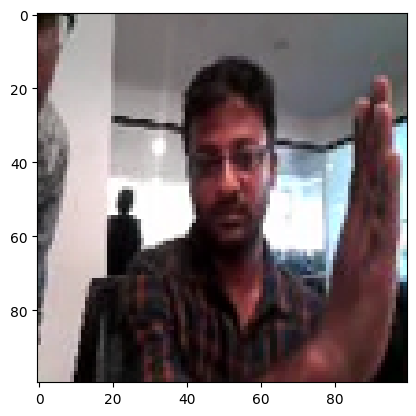

In [20]:
shifted = im.transform(im.size,Image.AFFINE,(1,0,np.random.randint(-30,30),0,1,np.random.randint(-30,30)))
gray = shifted.convert('L')
image = np.asarray(gray).astype(np.float32)
x0, y0 = np.argwhere(image > 0).min(axis=0)
x1, y1 = np.argwhere(image > 0).max(axis=0)

cropped = shifted.crop((y0,x0,y1,x1))
im_resized = cropped.resize(size=(100,100))
plt.imshow(im_resized)

In [21]:
print(x0,y0,x1,y1)

0 0 107 153


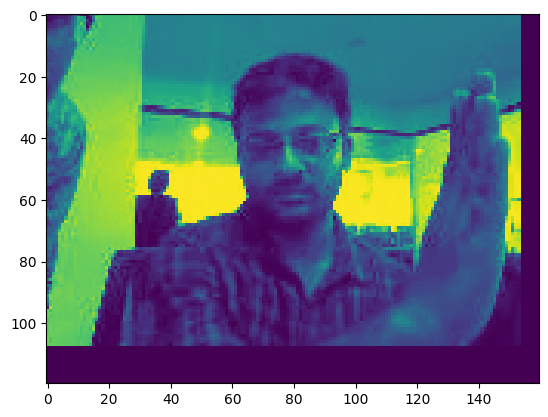

In [22]:
plt.imshow(gray)

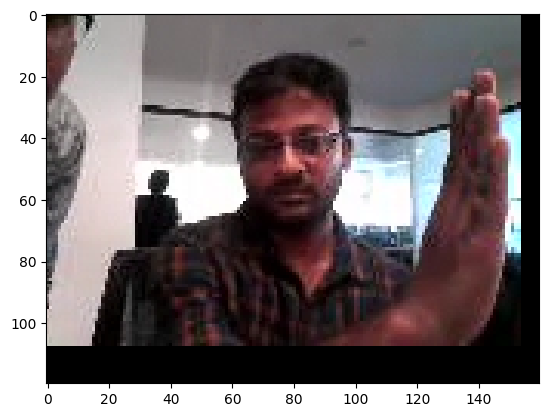

In [23]:
plt.imshow(shifted)

In [24]:
#Image Augmentation Function
def image_augment(image,y,z):
  shifted = image.transform(image.size,Image.AFFINE,(1,0,np.random.randint(-30,30),0,1,np.random.randint(-30,30)))
  gray = shifted.convert('L')
  im = np.asarray(gray).astype(np.float32)
  x0, y0 = np.argwhere(im > 0).min(axis=0)
  x1, y1 = np.argwhere(im > 0).max(axis=0)

  cropped = shifted.crop((y0,x0,y1,x1))
  im_resized = np.asarray(cropped.resize(size=(y,z))).astype(np.float32)
  return(im_resized)

## Generator with Data Augmentation techniques

In [25]:
def generator_with_aug(source_path, folder_list, batch_size,y,z,normalise,augment = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size,';Image resolution = ({},{})'.format(y,z))
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  int(len(t)/batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            # Newly added code for data augmentation
            if(augment == True):
              batch_data_aug = np.zeros((batch_size,x,y,z,3)) # batch_data_aug is used to store the augmented data

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    # Newly added code for data augmentation(Translate the image randomly, crop and resize )
                    if( augment == True):
                      im_aug = image_augment(image,y,z)


                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if(image.size[0] == 160): # crop the image of shape 120 X 160 to make it  120 X120
                      image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120

                    image = image.resize(size = (y,z)) #imageio.imresize(image,(y,z)).astype(np.float32)
                    image = np.asarray(image).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

                    #Newly added code( Normalise the augmented image data)
                    if(augment == True):
                      batch_data_aug[folder,idx,:,:,0] = normalise(im_aug[:,:,0])
                      batch_data_aug[folder,idx,:,:,1] = normalise(im_aug[:,:,1])
                      batch_data_aug[folder,idx,:,:,2] = normalise(im_aug[:,:,2])

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


            # Newly added code(Concatinate the augmented data to the batch_data and their corresponding batch_labels
            if(augment == True):
              batch_data=np.concatenate([batch_data,batch_data_aug])
              batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches

        if (len(t) % batch_size) != 0:
          batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
          batch_labels = np.zeros((len(t)%batch_size,5))
          if(augment == True):
             batch_data_aug = np.zeros((len(t)%batch_size,x,y,z,3)) # batch_data_aug is used to store the augmented data

          for folder in range(len(t)%batch_size):
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
              image = Image.open(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])

              # Newly added code for data augmentation(Translate the image randomly, crop and resize )
              if(augment==True):
                im_aug = image_augment(image,y,z)

              if image.size[0] == 160:
                image = image.crop((20,0,140,120)) # left =20, top =0, right = 140, bottom = 120

              image = image.resize(size = (y,z))
              image = np.asarray(image).astype(np.float32)


              batch_data[folder,idx,:,:,0] = normalise(image[:,:,0])  #normalise and feed in the image
              batch_data[folder,idx,:,:,1] = normalise(image[:,:,1]) #normalise and feed in the image
              batch_data[folder,idx,:,:,2] = normalise(image[:,:,2]) #normalise and feed in the image

              #Newly added code( Normalise the augmented image data)
              if(augment == True):
                batch_data_aug[folder,idx,:,:,0] = normalise(im_aug[:,:,0])
                batch_data_aug[folder,idx,:,:,1] = normalise(im_aug[:,:,1])
                batch_data_aug[folder,idx,:,:,2] = normalise(im_aug[:,:,2])

            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

          #Newly added code(Concatinate the augmented data to the batch_data and their corresponding batch_labels
          if(augment==True):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

          yield batch_data, batch_labels

# Model 8.1: Conv3D Archtecture with data augmentation
## Build the Conv3D model with data augmentation

1. batch_size =20
2. num_epochs = 20
3. Image Resolution=(100,100)

In [ ]:
def Conv3dArchitecture(x,y,z):
  conv3d_model = Sequential()
  conv3d_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d_model.add(BatchNormalization())
  conv3d_model.add(Activation('relu'))
  conv3d_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d_model.add(Flatten())
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(512, activation='relu'))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 20

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [ ]:
# Compile the conv3d_model
# Using sgd optimizer
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
conv3d_model1 = Conv3dArchitecture(x,y,z)
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

In [ ]:
# Call the file path creating callback_dirctory function
callbacks_list = callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation dataset
# The generator will creates batch_size * 2 data {(raw_data) + (augmented_data)} for one batch
# But number of steps per epoch is same but for each batch number of samples increased

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size ) + 1
# batch size of validation data should be
if (num_val_sequences%(batch_size)) == 0:
    validation_steps = int(num_val_sequences/(batch_size))
else:
    validation_steps = (num_val_sequences//(batch_size)) + 1


# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator_with_aug(train_path, train_doc, batch_size,y,z,normalise,augment=True)
val_generator = generator_with_aug(val_path, val_doc, batch_size,y,z,normalise)

#Fit the model
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



In [ ]:
plot(history_model1,20)

# Note: Good Model

**Decision:**
1. Save the final epoch model for future use
2. We can run this model for some more epochs to get the good accuracy

# Model 9
Lets apply augmentation on our best model so far which is 7.2

In [ ]:
def cnn_lstm_gru(x,y,z, dropout):

  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y,z,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)

  for layer in base_model.layers:
      layer.trainable = False

  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(64, return_sequences=True))
  model.add(Dropout(dropout))
  model.add(GRU(32))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(5, activation='softmax'))
  return model


In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 20 # choose the number of epochs
batch_size = 32
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/dataset/Project_data/train'
val_path = '/dataset/Project_data/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam(learning_rate=0.0001)
model9 = cnn_lstm_gru(x,y,z,0.25)
model9.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

In [ ]:
# Call the file path creating callback_dirctory function
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator_with_aug(train_path, train_doc, batch_size,y,z,normalise, True)
val_generator = generator_with_aug(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
#Fit the model

history_model9 = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot(history_model9)


**Observation**
1. Training Accuracy: 97.6
2. Validation Accuracy: 82
3. Train Loss: 0.21
4. Val Loss: 0.66
5. This model is overfitting and we need to control the same.

# Model 10
Transfer Learrning using Mobilenet and GRU

In [3]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


NameError: name 'mobilenet' is not defined

In [27]:
def cnn_gru(x,y,z,dropout):
  model = Sequential()
  model.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))

  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Flatten()))

  model.add(GRU(128))
  model.add(Dropout(dropout))

  model.add(Dense(128,activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(5, activation='softmax'))
  return model

In [28]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()
num_epochs = 10 # choose the number of epochs
batch_size = 16
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

# Set the training and validation data set path
train_path = '/content/drive/MyDrive/gesture/train'
val_path = '/content/drive/MyDrive/gesture/val'

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [2]:
# Compile the conv3d_model
# Using Adam optimizer

adam = optimizers.Adam(learning_rate=0.0001)
model10 = cnn_gru(x,y,z,0.25)
model10.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model10.summary())

NameError: name 'optimizers' is not defined

In [30]:
# Call the file path creating callback_dirctory function
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.

normalise = lambda a: a/255.
train_generator = generator_with_aug(train_path, train_doc, batch_size,y,z,normalise, True)
val_generator = generator_with_aug(val_path, val_doc, batch_size,y,z,normalise)

In [31]:
#Fit the model
history_model10 = model10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /content/drive/MyDrive/gesture/train ; batch size = 16 ;Image resolution = (100,100)
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 217s/step - categorical_accuracy: 0.2887 - loss: 1.6286  Source path =  /content/drive/MyDrive/gesture/val ; batch size = 16 ;Image resolution = (100,100)

Epoch 1: saving model to model_init_2025-04-0210_36_57.812679/model-00001-1.50298-0.36802-1.00159-0.69000.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 10648s 257s/step - categorical_accuracy: 0.2906 - loss: 1.6257 - val_categorical_accuracy: 0.6900 - val_loss: 1.0016 - learning_rate: 1.0000e-04
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7007 - loss: 0.9113
Epoch 2: saving model to model_init_2025-04-0210_36_57.812679/model-00002-0.85504-0.71418-0.60757-0.79000.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - categorical_accuracy: 0.7011 - loss: 0.9100 - val_categorical_accuracy: 0.7900 - val_loss: 0.6076 - learning_rate: 1.0000e-04
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8543 - loss: 0.5272
Epoch 3: saving model to model_init_2025-04-0210_36_57.812679/model-00003-0.48644-0.86199-0.39792-0.89000.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - categorical_accuracy: 0.8545 - loss: 0.5262 - val_categorical_accuracy: 0.8900 - val_loss: 0.3979 - learning_rate: 1.0000e-04
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9273 - loss: 0.3106
Epoch 4: saving model to model_init_2025-04-0210_36_57.812679/model-00004-0.29914-0.92383-0.32413-0.87500.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - categorical_accuracy: 0.9272 - loss: 0.3104 - val_categorical_accuracy: 0.8750 - val_loss: 0.3241 - learning_rate: 1.0000e-04
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9543 - loss: 0.1879
Epoch 5: saving model to model_init_2025-04-0210_36_57.812679/model-00005-0.20778-0.93891-0.27014-0.90179.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - categorical_accuracy: 0.9539 - loss: 0.1884 - val_categorical_accuracy: 0.9018 - val_loss: 0.2701 - learning_rate: 1.0000e-04
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9688 - loss: 0.1348
Epoch 6: saving model to model_init_2025-04-0210_36_57.812679/model-00006-0.12244-0.97587-0.22899-0.89286.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - categorical_accuracy: 0.9690 - loss: 0.1345 - val_categorical_accuracy: 0.8929 - val_loss: 0.2290 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9789 - loss: 0.0999
Epoch 7: saving model to model_init_2025-04-0210_36_57.812679/model-00007-0.10648-0.97436-0.14894-0.93750.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - categorical_accuracy: 0.9788 - loss: 0.1000 - val_categorical_accuracy: 0.9375 - val_loss: 0.1489 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9717 - loss: 0.1069
Epoch 8: saving model to model_init_2025-04-0210_36_57.812679/model-00008-0.11401-0.96833-0.14756-0.92857.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - categorical_accuracy: 0.9716 - loss: 0.1071 - val_categorical_accuracy: 0.9286 - val_loss: 0.1476 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9819 - loss: 0.0711
Epoch 9: saving model to model_init_2025-04-0210_36_57.812679/model-00009-0.06701-0.98190-0.11050-0.97000.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - categorical_accuracy: 0.9819 - loss: 0.0710 - val_categorical_accuracy: 0.9700 - val_loss: 0.1105 - learning_rate: 1.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9939 - loss: 0.0453
Epoch 10: saving model to model_init_2025-04-0210_36_57.812679/model-00010-0.05318-0.98944-0.09810-0.97000.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - categorical_accuracy: 0.9938 - loss: 0.0455 - val_categorical_accuracy: 0.9700 - val_loss: 0.0981 - learning_rate: 1.0000e-04


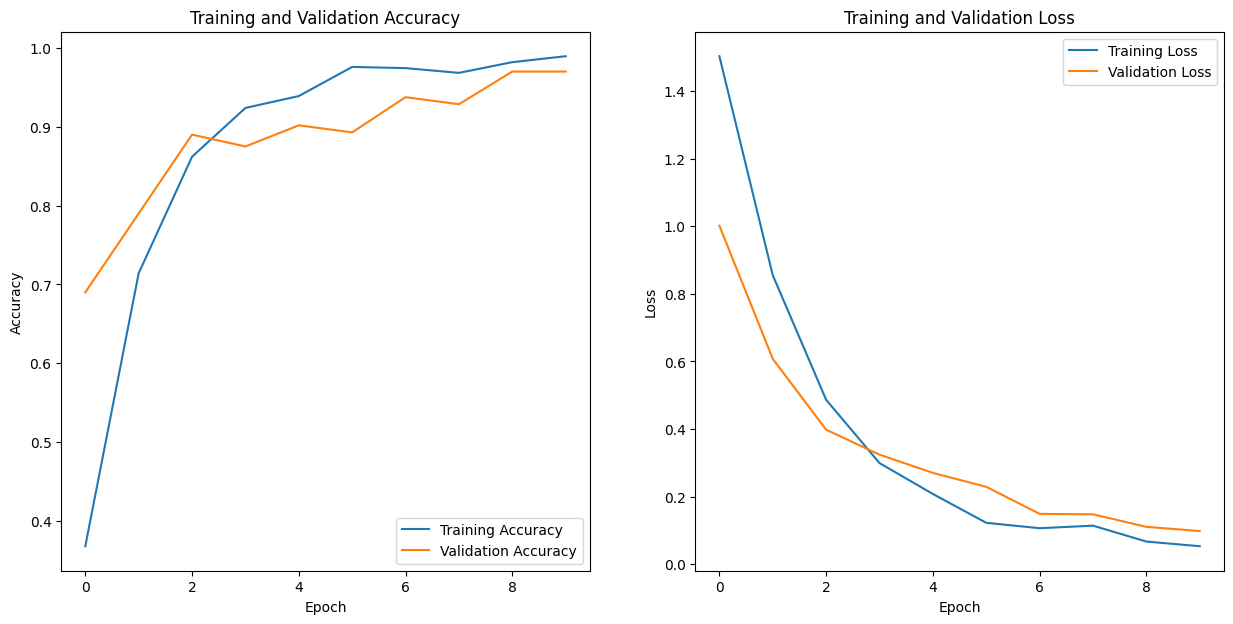

In [32]:
plot(history_model10)

In [38]:
# Save the trained model
save_path = "/content/drive/MyDrive/model_acc/model_acc.h5"  # Change this to your desired path
model10.save(save_path)
print(f"Model saved at: {save_path}")
print("Model saved successfully!")

Model saved at: /content/drive/MyDrive/model_acc/model_acc.h5
Model saved successfully!


################################# wait a sec ###################################



In [33]:
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install tensorflow-addons --upgrade --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 w

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [1]:
import tensorflow as tf

save_path_tflite = "/content/drive/MyDrive/model_acc/model_acc.tflite"

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model10)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: Quantization

# Enable TF Select to support MaxPool3D
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()

# Save the TFLite model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved as model.tflite")

# Save the TFLite model
with open(save_path_tflite, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {save_path_tflite}")
print("TFLite model saved as model.tflite")

NameError: name 'model10' is not defined

In [36]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 87.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.18.0
    Uninstalling tf_keras-2.18.0:
      Successfully uninstalled tf_keras-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible

In [39]:
import tensorflow as tf

# Path to your saved .h5 model
h5_model_path = "/content/drive/MyDrive/model_acc/model_acc.h5"

# Load the Keras model
model = tf.keras.models.load_model(h5_model_path)

# Verify the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 18, 3, 3, 1024)      │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 18, 3, 3, 1024)      │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 18, 1, 1, 1024)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 18, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │         443,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,693,255 (14.09 MB)

 Trainable params: 3,669,317 (14.00 MB)

 Non-trainable params: 23,936 (93.50 KB)

 Optimizer params: 2 (12.00 B)

In [40]:
!pip install tensorflow==2.18.0  # Install a compatible TensorFlow version
!pip install tensorflow-text==2.18.1  # Align with the selected TensorFlow version
!pip install tensorflow-addons==0.20.0  # Ensure compatible tensorflow-addons
!pip install tensorflowjs --upgrade # Upgrade tensorflowjs again
!pip install packaging==23.1  # align with the selected packaging version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 833.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have te

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 27.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.9 MB)
Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting u

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.2
    Uninstalling packaging-23.2:
      Successfully uninstalled packaging-23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.1 which is incompatible.
langsmith 0.3.19 requires packaging>=23.2, but you have packaging 23.1 which is incompatible.
langchain-core 0.3.49 requires packaging<25,>=23.2, but you have packaging 23.1 which is incompatible.
xarray 2025.1.2 requires packaging>=23.2, but you have packaging 23.1 which is incompatible.


In [42]:
import tensorflowjs as tfjs

# Define output directory for TFJS model
tfjs_output_dir = "/content/drive/MyDrive/model_acc/tfjs"

# Convert the Keras model to TensorFlow.js format
tfjs.converters.save_keras_model(model, tfjs_output_dir)

print(f"TensorFlow.js model saved at {tfjs_output_dir}")

ImportError: cannot import name 'float8_e4m3b11fnuz' from 'tensorflow.python.framework.dtypes' (/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/dtypes.py)

In [ ]:
import shutil
from google.colab import files

# Zip the TFJS model folder
shutil.make_archive("tfjs_model", 'zip', tfjs_output_dir)

# Download the file
files.download("tfjs_model.zip")


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/models/model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']

print("Output shape:", output_shape)
print("Number of classes:", output_shape[-1])

# Print model details
print("Input Details:", input_details)
print("Output Details:", output_details)

# Load and preprocess the input image
def preprocess_image(image_paths, target_size):
    """Loads and preprocesses a sequence of images."""
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    processed_images = []

    for idx, item in enumerate(img_idx):
        image = image_paths[item]
        image = cv2.imread(image)  # Load image
        image = cv2.resize(image, target_size)  # Resize to model input size
        image = image.astype(np.float32) / 255.0  # Normalize

        processed_images.append(image)

    input_data = np.stack(processed_images, axis=0)
    input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension

    return input_data

# Path to the test image
image_dir = "/content/drive/MyDrive/gesture/train/WIN_20180907_16_29_34_Pro_Right Swipe_new"
target_size = (100, 100)
image_paths = [os.path.join(image_dir, filename) for filename in sorted(os.listdir(image_dir))]

# Preprocess the image
input_data = preprocess_image(image_paths, target_size)

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get output predictions
output_data = interpreter.get_tensor(output_details[0]['index'])[0]  # Extract batch index 0

# Print classification results
predicted_class = np.argmax(output_data)  # Get class with highest probability
print("Predicted Class:", predicted_class)

# Print confidence scores for all 5 classes
for i, confidence in enumerate(output_data):
    print(f"Class {i}: {confidence:.4f}")


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/models/model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print model details (optional)
# print("Input Details:", input_details)
# print("Output Details:", output_details)


# Load and preprocess the input image
def preprocess_image(image_paths, target_size):
    """Loads and preprocesses a sequence of images."""
    img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
    processed_images = []

    for idx, item in enumerate(img_idx):
        image = image_paths[item]
        image = cv2.imread(image)  # Load image
        image = cv2.resize(image, target_size)  # Resize to model input size
        image = image.astype(np.float32) / 255.0  # Normalize
        processed_images.append(image)

    # Stack images to create sequence and add batch dimension
    input_data = np.stack(processed_images, axis=0)
    input_data = np.expand_dims(input_data, axis=0)

    return input_data

# Path to the test images (directory containing a sequence)
image_dir = "/content/drive/MyDrive/gesture/train/WIN_20180907_16_35_51_Pro_Right Swipe_new"
target_size = (100, 100)
image_paths = [os.path.join(image_dir, filename) for filename in sorted(os.listdir(image_dir))]

# Preprocess the image sequence
input_data = preprocess_image(image_paths, target_size)

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get output predictions
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

# Print classification results
predicted_class = np.argmax(output_data)
print("Predicted Class:", predicted_class)

# Print confidence scores for all 5 classes
for i, confidence in enumerate(output_data):
    print(f"Class {i}: {confidence:.4f}")

In [ ]:
print(history.history['loss'])
print(history.history['categorical_accuracy'])
print(history.history['val_loss'])
print(history.history['val_categorical_accuracy'])

In [ ]:
pip install tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 0



**Observation**
1. Training Accuracy: 99.6
2. Validation Accuracy: 94
3. Train Loss: 0.027
4. Val Loss: 0.14
5. Best Model with highest training and validation accuracy.